In [61]:
import pandas as pd
import numpy as np
import textgrids
import librosa

In [62]:
import os # Working with directories
import python_speech_features # For exctracting features for deep learning
from tqdm import tqdm # Progress meter
from sklearn import model_selection, preprocessing, metrics # Preparation data
from tensorflow.keras import models, layers
import tensorflow as tf
from tensorflow.keras import backend as K

In [63]:
# Function for reading labels from .TextGrig file:
def readLabels(path, sample_rate):
        
    labeled_list  = []
    grid = textgrids.TextGrid(path)

    for interval in grid['silences']:
        label = int(interval.text)

        dur = interval.dur
        dur_samples = int(np.round(dur * sample_rate)) # sec -> num of samples
        
        for i in range(dur_samples):
            labeled_list.append(label)

    return labeled_list

In [64]:
np.sum(np.array(readLabels('Data/Annotation/Female/TMIT/SA1.TextGrid', 16000)))

39168

In [65]:
# Function for getting all files in directories and sub-directories with definite extension:
def getFiles(path, extension):
    list_paths = list()
    for root, dirs, files in os.walk(path):
        for file in files:
            if(file.endswith(extension)):
                list_paths.append(os.path.join(root, file))
    return list_paths

In [66]:
annotation_path = 'Data/Annotation/'
annotation_extension = '.TextGrid'
audio_path = 'Data/Audio/'
audio_extension = '.wav'

annotation_files = getFiles(path=annotation_path, extension=annotation_extension)
audio_files = getFiles(path=audio_path, extension=audio_extension)
annotation_files = sorted(annotation_files)
audio_files = sorted(audio_files)

print(audio_files)

print('Number of files:', len(audio_files))

['Data/Audio/Female/PTDB-TUG/mic_F01_sa2.wav', 'Data/Audio/Female/PTDB-TUG/mic_F01_si454.wav', 'Data/Audio/Female/PTDB-TUG/mic_F01_si473.wav', 'Data/Audio/Female/PTDB-TUG/mic_F01_si502.wav', 'Data/Audio/Female/PTDB-TUG/mic_F01_si523.wav', 'Data/Audio/Female/PTDB-TUG/mic_F01_si528.wav', 'Data/Audio/Female/PTDB-TUG/mic_F01_si575.wav', 'Data/Audio/Female/PTDB-TUG/mic_F01_si606.wav', 'Data/Audio/Female/PTDB-TUG/mic_F01_si629.wav', 'Data/Audio/Female/PTDB-TUG/mic_F01_si640.wav', 'Data/Audio/Female/PTDB-TUG/mic_F01_sx16.wav', 'Data/Audio/Female/PTDB-TUG/mic_F01_sx42.wav', 'Data/Audio/Female/PTDB-TUG/mic_F02_sa1.wav', 'Data/Audio/Female/PTDB-TUG/mic_F02_si654.wav', 'Data/Audio/Female/PTDB-TUG/mic_F02_si675.wav', 'Data/Audio/Female/PTDB-TUG/mic_F02_si698.wav', 'Data/Audio/Female/PTDB-TUG/mic_F02_si737.wav', 'Data/Audio/Female/PTDB-TUG/mic_F02_si772.wav', 'Data/Audio/Female/PTDB-TUG/mic_F02_si790.wav', 'Data/Audio/Female/PTDB-TUG/mic_F02_si791.wav', 'Data/Audio/Female/PTDB-TUG/mic_F02_si817.wav

In [67]:
# Set params for model:
preemphasis_coef = 0.97 # Coefficient for pre-processing filter
frame_length = 0.025 # Window length in sec
frame_step = 0.01 # Length of step in sec
num_nfft = 512 # Point for FFT
num_features = 32 # Number of Mel filters
n_frames = 32 # Number of frames for uniting in image

In [68]:
# Extraction features for each file:
dataset = list()
for i in tqdm(range(len(audio_files))):
    sig, sample_rate = librosa.load(audio_files[i])
    markers = readLabels(path=annotation_files[i], sample_rate=sample_rate)
    
    # Extract logfbank features:
    features_logfbank = python_speech_features.base.logfbank(signal=sig, samplerate=sample_rate, winlen=frame_length, winstep=frame_step, nfilt=num_features, 
                                                                        nfft=num_nfft, lowfreq=0, highfreq=None, preemph=preemphasis_coef)
    
    # Reshape labels for each group of features:
    markers_of_frames = python_speech_features.sigproc.framesig(sig=markers, frame_len=frame_length * sample_rate, frame_step=frame_step * sample_rate, 
                                                                winfunc=np.ones)
    
    # For every frame calc label:
    marker_per_frame = np.zeros(markers_of_frames.shape[0])
    marker_per_frame = np.array([1 if np.sum(markers_of_frames[j], axis=0) > markers_of_frames.shape[0] / 2 else 0 for j in range(markers_of_frames.shape[0])])
    
    spectrogram_image = np.zeros((n_frames, n_frames))
    for j in range(int(np.floor(features_logfbank.shape[0] / n_frames))):
        spectrogram_image = features_logfbank[j * n_frames:(j + 1) * n_frames]
        label_spectrogram_image = 1 if np.sum(marker_per_frame[j * n_frames:(j + 1) * n_frames]) > n_frames / 2 else 0
        dataset.append((label_spectrogram_image, spectrogram_image))

100%|██████████| 719/719 [00:34<00:00, 21.03it/s]


In [69]:
markers_of_frames.shape
print(dataset[0][1].shape)


(32, 32)


In [70]:
# Split dataset on train and test:
X = list()
y = list()
for i in range(len(dataset)):
    X.append(dataset[i][1])
    y.append(dataset[i][0])
    

X = np.array(X)
y = np.array(y)

print(X.shape)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, shuffle=True, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Reshaping for scaling:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
    
# Scale data:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# And reshape back:
X_train = X_train.reshape(X_train.shape[0], n_frames, n_frames)
X_test = X_test.reshape(X_test.shape[0], n_frames, n_frames)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9467, 32, 32)
(6342, 32, 32) (3125, 32, 32) (6342,) (3125,)
(6342, 32, 32) (3125, 32, 32) (6342,) (3125,)


In [71]:
# Encoding label:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [72]:
# Reshape data for convolution layer:
stride = int(15)


X_train_reshaped = X_train[:int(np.floor(X_train.shape[0] / stride) * stride)]
print(X_train_reshaped.shape)
X_test_reshaped = X_test[:int(np.floor(X_test.shape[0] / stride) * stride)]

y_train_reshaped = y_train[:int(np.floor(X_train.shape[0] / stride) * stride)]
y_test_reshaped = y_test[:int(np.floor(X_test.shape[0] / stride) * stride)]

print(X_train_reshaped.shape, X_test_reshaped.shape, y_train_reshaped.shape, y_test_reshaped.shape)

X_train_reshaped = X_train_reshaped.reshape((int(X_train_reshaped.shape[0] / stride), stride, n_frames, n_frames, 1))
X_test_reshaped = X_test_reshaped.reshape((int(X_test_reshaped.shape[0] / stride), stride, n_frames, n_frames, 1))

print(X_train_reshaped.shape, X_test_reshaped.shape, y_train_reshaped.shape, y_test_reshaped.shape)

y_train_reshaped = y_train_reshaped.reshape((int(y_train_reshaped.shape[0] / stride), stride, y_train[-1].shape[0]))
y_test_reshaped = y_test_reshaped.reshape((int(y_test_reshaped.shape[0] / stride), stride, y_test[-1].shape[0]))
print(X_train_reshaped.shape, X_test_reshaped.shape, y_train_reshaped.shape, y_test_reshaped.shape)

(6330, 32, 32)
(6330, 32, 32) (3120, 32, 32) (6330, 2) (3120, 2)
(422, 15, 32, 32, 1) (208, 15, 32, 32, 1) (6330, 2) (3120, 2)
(422, 15, 32, 32, 1) (208, 15, 32, 32, 1) (422, 15, 2) (208, 15, 2)


In [73]:
X_train_reshaped.shape

(422, 15, 32, 32, 1)

In [74]:
model = models.Sequential()
model.add(layers.TimeDistributed(layers.Conv2D(128, (5, 5), activation='elu'), input_shape=(stride, n_frames, n_frames, 1)))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='elu')))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='elu')))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Flatten()))
model.add(layers.TimeDistributed(layers.Dense(64, activation='elu')))
model.add(layers.Dropout(0.5))
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
model.add(layers.Dropout(0.5))
model.add(layers.TimeDistributed(layers.Dense(y_train[-1].shape[0], activation='softmax')))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', ])

In [97]:
from tensorflow.keras.utils import plot_model

plot_model(model, 'model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [76]:
epochs = 25
batch_size = 32
callbacks = None

history = model.fit(
    X_train_reshaped, y_train_reshaped,
    validation_data=(X_test_reshaped, y_test_reshaped),
    epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Epoch 1/25
14/14 [==============================] - 19s 1s/step - loss: 0.4594 - accuracy: 0.7932 - val_loss: 0.3657 - val_accuracy: 0.8657
Epoch 2/25
14/14 [==============================] - 15s 1s/step - loss: 0.3598 - accuracy: 0.8550 - val_loss: 0.3111 - val_accuracy: 0.8712
Epoch 3/25
14/14 [==============================] - 17s 1s/step - loss: 0.3348 - accuracy: 0.8618 - val_loss: 0.2935 - val_accuracy: 0.8696
Epoch 4/25
14/14 [==============================] - 16s 1s/step - loss: 0.3182 - accuracy: 0.8649 - val_loss: 0.2735 - val_accuracy: 0.8715
Epoch 5/25
14/14 [==============================] - 17s 1s/step - loss: 0.3004 - accuracy: 0.8673 - val_loss: 0.2706 - val_accuracy: 0.8708
Epoch 6/25
14/14 [==============================] - 21s 2s/step - loss: 0.2916 - accuracy: 0.8719 - val_loss: 0.2924 - val_accuracy: 0.8808
Epoch 7/25
14/14 [==============================] - 17s 1s/step - loss: 0.2864 - accuracy: 0.8708 - val_loss: 0.2566 - val_accuracy: 0.8808
Epoch 8/25
14/14 [==

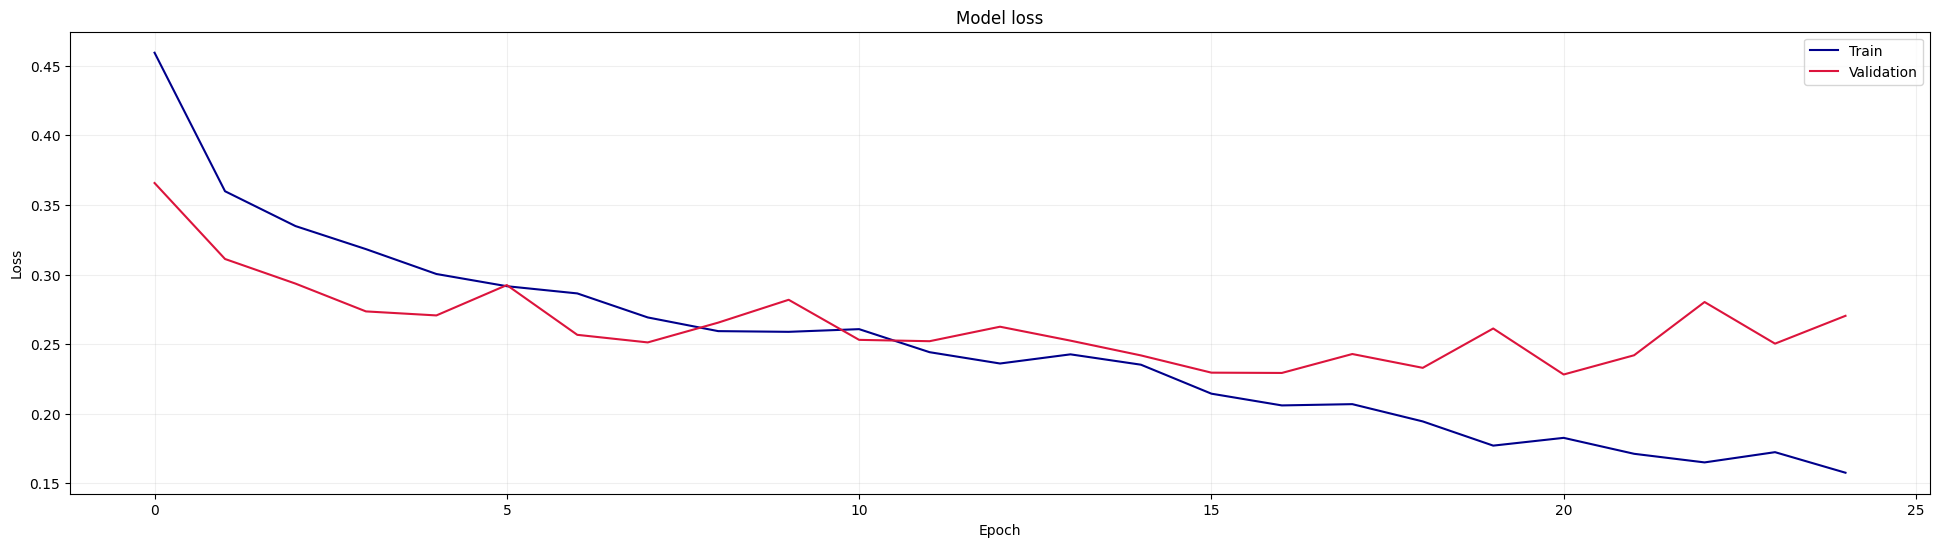

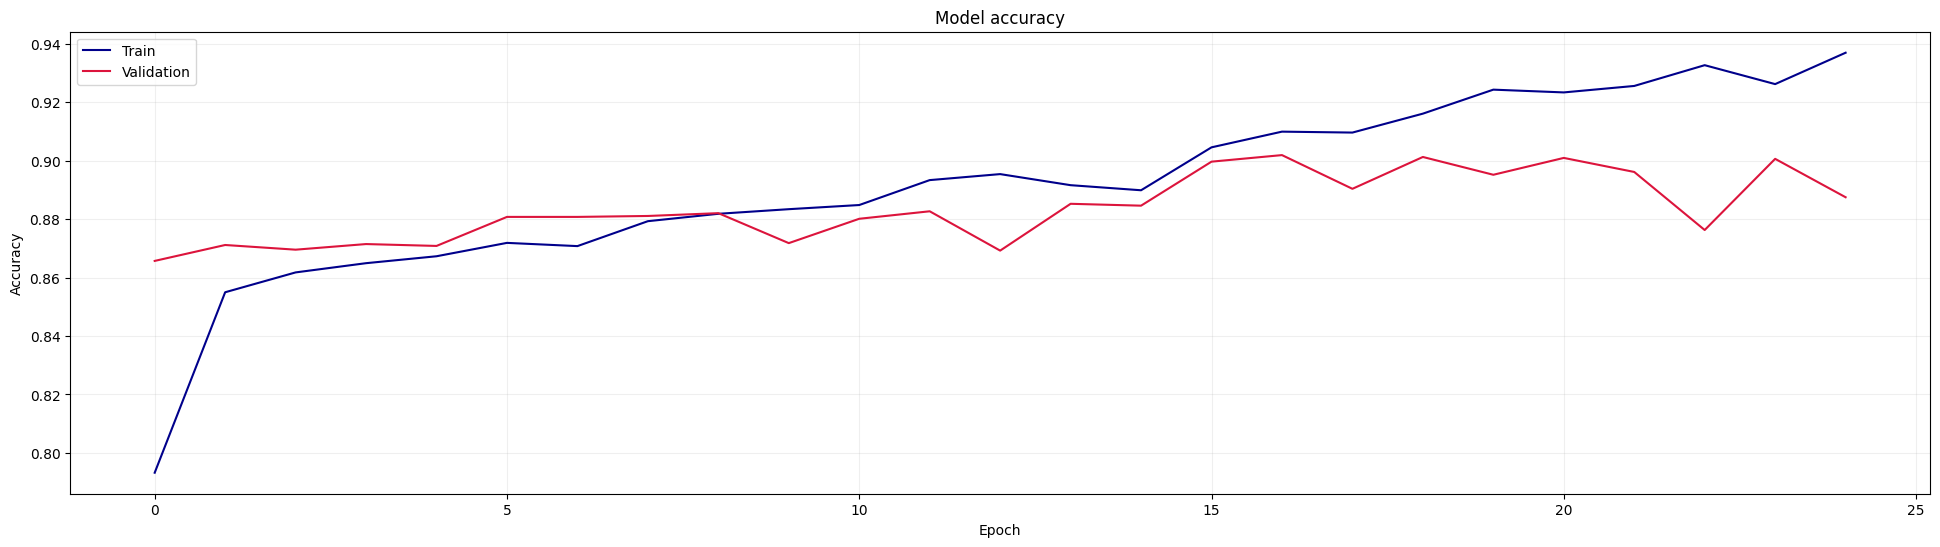

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [77]:
import matplotlib.pyplot as plt
def plot_loss(history):
    plt.figure(figsize=(24, 6))
    plt.plot(history.history['loss'], c ="darkblue")
    plt.plot(history.history['val_loss'], c ="crimson")
    plt.legend(["Train", "Validation"])
    plt.title("Model loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, alpha = 0.2)
    plt.show()
    

def plot_accuracy(history):
    plt.figure(figsize=(24, 6))
    plt.plot(history.history['accuracy'], c ="darkblue")
    plt.plot(history.history['val_accuracy'], c ="crimson")
    plt.legend(["Train", "Validation"])
    plt.title("Model accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, alpha = 0.2)
    plt.show() 

    
plot_loss(history)
plot_accuracy(history)

model.save('model1.h5')

In [78]:


annotation_file = "Data/Annotation/Female/TMIT/SA1.TextGrid"
audio_file = "Data/Audio/Female/TMIT/SA1.wav"

dataset_valid = list()

# Load samples:
input_signal, fs = librosa.load(audio_file)

# Load labels:
truth_labels = readLabels(path=annotation_file, sample_rate=fs)

# Extract logfbank features:
features_logfbank_valid = python_speech_features.base.logfbank(signal=input_signal, samplerate=fs, winlen=frame_length, winstep=frame_step, nfilt=num_features, 
                                                               nfft=num_nfft, lowfreq=0, highfreq=None, preemph=preemphasis_coef)

# Reshape labels for each group of features:
marker_per_frames_truth = python_speech_features.sigproc.framesig(sig=truth_labels, frame_len=frame_length * fs, frame_step=frame_step * fs, 
                                                                 winfunc=np.ones)

# For every frame calc label:
marker_per_frame_truth = np.zeros(marker_per_frames_truth.shape[0])
marker_per_frame_truth = np.array([1 if np.sum(marker_per_frames_truth[j], axis=0) > marker_per_frames_truth.shape[0] / 2 else 0 
                                   for j in range(marker_per_frames_truth.shape[0])])

spectrogram_image_valid = np.zeros((n_frames, n_frames))
for j in range(int(np.floor(features_logfbank_valid.shape[0] / n_frames))):
    spectrogram_image_valid = features_logfbank_valid[j * n_frames:(j + 1) * n_frames]
    label_spectrogram_image_valid = 1 if np.sum(marker_per_frame_truth[j * n_frames:(j + 1) * n_frames]) > n_frames / 2 else 0
    dataset_valid.append((label_spectrogram_image_valid, spectrogram_image_valid))

In [87]:
stride = int(15)

if stride - len(dataset_valid) > 0:
    for i in range(stride - len(dataset_valid)):
        dataset_valid.append((0, np.zeros((n_frames, n_frames))))
        
print(dataset_valid)

[(0, array([[-24.23545656, -22.34525785, -22.32316033, ..., -21.12333288,
        -24.41492601, -24.49419989],
       [-22.09742277, -22.76381566, -21.64720595, ..., -21.01457765,
        -24.67521728, -24.64572042],
       [-24.3749293 , -22.51694114, -22.68534611, ..., -20.11005882,
        -22.20583249, -22.7438217 ],
       ...,
       [-14.58300384, -13.93422524, -12.1565566 , ..., -16.35726979,
        -18.42776182, -20.03990089],
       [-13.45864391, -13.14145511, -11.76037839, ..., -17.20603771,
        -19.34899192, -19.16447848],
       [-16.04131074, -15.39632309, -12.69225622, ..., -15.35879196,
        -15.90684544, -16.04334895]])), (1, array([[-13.82809586, -13.46049895, -11.82316217, ..., -15.15571047,
        -15.64758162, -15.70594372],
       [-13.78217932, -13.45546208, -11.69176141, ..., -15.74927113,
        -16.54618681, -16.61234094],
       [-14.75589894, -14.15939074, -11.50254187, ..., -16.85501238,
        -17.54433795, -17.23449053],
       ...,
       [-1

In [88]:
scaler = preprocessing.StandardScaler()

# Split dataset on train and test:
X_valid = list()
y_valid = list()
for i in range(len(dataset_valid)):
    X_valid.append(dataset_valid[i][1])
    y_valid.append(dataset_valid[i][0])
    
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

# Reshaping for scaling:
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1] * X_valid.shape[2])
    
# Scale data:
X_valid = scaler.fit_transform(X_valid)

# And reshape back:
X_valid = X_valid.reshape(X_valid.shape[0], n_frames, n_frames)

print(X_valid)

[[[-1.52626382 -1.33725455 -1.52789208 ... -1.32412422 -1.51865766
   -1.50309039]
  [-1.27373945 -1.43498713 -1.53883547 ... -1.28656954 -1.45953076
   -1.42223178]
  [-1.65635516 -1.51397288 -1.70044364 ... -1.23686316 -1.35847076
   -1.41303596]
  ...
  [-0.49047956 -0.47614595 -0.44194645 ... -0.71578711 -0.78194079
   -0.87118512]
  [-0.32618825 -0.3488002  -0.31117704 ... -0.78612515 -0.86114349
   -0.83604643]
  [-0.53956734 -0.50436878 -0.36244032 ... -0.60489142 -0.57720769
   -0.55993723]]

 [[-0.36782215 -0.34096918 -0.27364841 ... -0.61392595 -0.55092756
   -0.54213675]
  [-0.34856364 -0.36613883 -0.2985328  ... -0.66467613 -0.58671174
   -0.56987013]
  [-0.54005341 -0.51317563 -0.2951358  ... -0.8424875  -0.82244323
   -0.78160217]
  ...
  [-0.65295623 -0.73271968 -0.9426078  ... -0.71667893 -0.6820505
   -0.70325302]
  [-0.83111474 -0.93831168 -1.169069   ... -0.35750716 -0.25601923
   -0.25575615]
  [-0.36308416 -0.3908975  -0.59789566 ... -0.52037297 -0.44291527
   -0.4

In [81]:
# Encoding label:
y_truth = y_valid
y_valid = pd.get_dummies(y_valid)
y_valid = np.array(y_valid)

In [82]:
# Reshape data for convolution layer:
X_valid_reshaped = X_valid[:int(np.floor(X_valid.shape[0] / stride) * stride)]
y_valid_reshaped = y_valid[:int(np.floor(X_valid.shape[0] / stride) * stride)]

X_valid_reshaped = X_valid_reshaped.reshape((int(X_valid_reshaped.shape[0] / stride), stride, n_frames, n_frames, 1))
y_valid_reshaped = y_valid_reshaped.reshape((int(y_valid_reshaped.shape[0] / stride), stride, y_valid[-1].shape[0]))

In [83]:
prediction = model.predict(X_valid_reshaped)

predicted_label = np.zeros(prediction.shape[1])
predicted_proba = np.zeros(prediction.shape[1])
ind = 0
for i in range(prediction.shape[1]):
    if prediction[0][i][0] >= prediction[0][i][1]:
        predicted_label[ind] = 0
        predicted_proba[ind] = prediction[0][i][0]
    else:
        predicted_label[ind] = 1
        predicted_proba[ind] = prediction[0][i][1]
    ind = ind + 1
        
predicted_label

1/1 [==============================] - 1s 642ms/step


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.])

In [84]:
print(predicted_label, y_truth)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.] [0 1 1 1 1 1 1 1 1 0 0 0 0 0 0]


In [85]:
predicted_label_widely = np.zeros(predicted_label.shape[0] * n_frames)
ind_start = 0
ind_stop = n_frames
shift_step = n_frames
for i in range(predicted_label.shape[0]):
    predicted_label_widely[ind_start:ind_stop] = predicted_label[i]
    ind_start = ind_start + shift_step
    ind_stop = ind_stop + shift_step

label_timeseries = np.zeros(input_signal.shape[0])
begin = int(0)
end = int(frame_length * fs)
shift_step = int(frame_step * fs)
for i in range(predicted_label_widely.shape[0]):
    label_timeseries[begin:end] = predicted_label_widely[i]
    begin = begin + shift_step
    end = end + shift_step
    print(label_timeseries)

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0.

[0.00000000e+00 4.53514739e-05 9.07029478e-05 ... 2.92471655e+00
 2.92476190e+00 2.92480726e+00]
64491


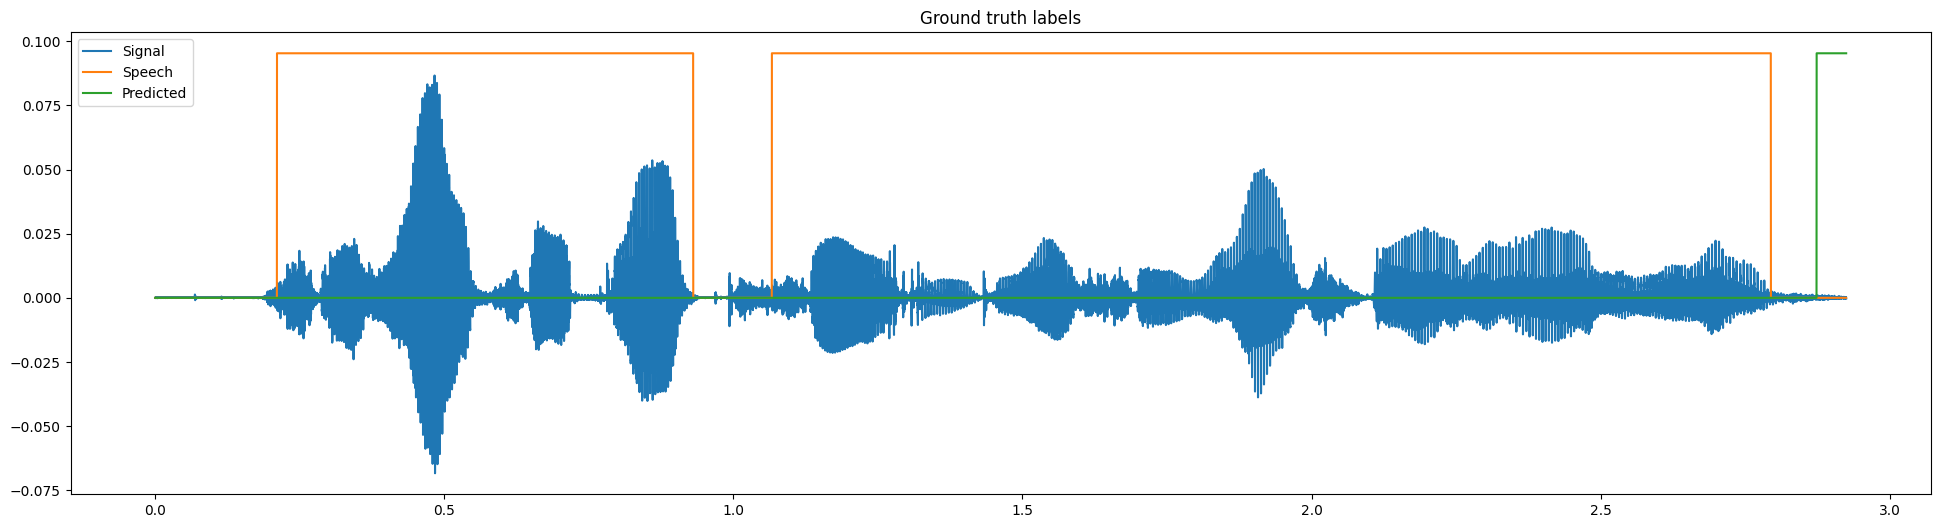

In [91]:
# define time axis
Ns = len(input_signal)  # number of sample
Ts = 1 / fs  # sampling period
t = np.arange(Ns) * Ts  # time axis in seconds
norm_coef = 1.1 * np.max(input_signal)

edge_ind = np.min([input_signal.shape[0], len(truth_labels)])

print(edge_ind)

plt.figure(figsize=(24, 6))
plt.plot(t[:edge_ind], input_signal[:edge_ind])
plt.plot(t[:edge_ind], np.array(truth_labels[:edge_ind]) * norm_coef)
plt.plot(t[:edge_ind], label_timeseries[:edge_ind] * norm_coef)

plt.title("Ground truth labels")
plt.legend(['Signal', 'Speech', 'Predicted'])
plt.show()